## 5.1

### 5.1.1

In [2]:
import torch
from torch import nn
from torch.nn.functional import cross_entropy
from torch.optim import AdamW
from model import GPTModel

In [3]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_len": 256, # changed from 1024 to 256 for making it run on normal machines
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate_emb": 0.1,
    "drop_rate_sc": 0.1,
    "drop_rate_mha": 0.1,
    "qkv_bias": False
}

In [4]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (mha): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=False)
        (W_k): Linear(in_features=768, out_features=768, bias=False)
        (W_v): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout_sc): Dropout(p=0.1, inplace=False)
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (1): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (mha): MultiHeadAttenti

In [5]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_count = idx[:, -context_size:] # (batch, n_tokens)
        with torch.no_grad():
            logits = model(idx_count)

        logits = logits[:, -1, :] # (batch, n_token, vocab_size)
        probs = torch.softmax(logits, dim=-1) # (batch, vocab_size)
        idx_next = torch.argmax(probs, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    
    return idx

In [6]:
import tiktoken

def text_to_token_ids(text: str, tokenizer: tiktoken.Encoding):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    enocded_tensor = torch.tensor(encoded).unsqueeze(0)
    return enocded_tensor

def token_ids_to_text(token_ids, tokenizer: tiktoken.Encoding):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

In [7]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_len"]
)
print(token_ids)
print(token_ids_to_text(token_ids, tokenizer))

tensor([[ 6109,  3626,  6100,   345, 34245,  5139,  2492, 25405, 17434, 17853,
          5308,  3398, 13174, 43071]])
Every effort moves you rentingetic wasnم refres RexMeCHicular stren


### 5.1.3

In [8]:
with open("TheVerdict.txt", 'r', encoding='utf-8') as f:
    text_data = f.read()

total_char = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print(total_char, total_tokens)

20479 5145


In [9]:
train_ratio = 0.9
train_data = text_data[: int(0.9*len(text_data))]
val_data = text_data[int(0.9*len(text_data)):]

In [10]:
# from chapter02.ipynb
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_len, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)

        for i in range(0, len(token_ids)-max_len, stride):
            x = token_ids[i: i+max_len]
            y = token_ids[i+1: i+max_len+1]
            self.input_ids.append(torch.tensor(x))
            self.target_ids.append(torch.tensor(y))
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, index):
        return self.input_ids[index], self.target_ids[index]
    

def create_dataloader_v1(txt: str, batch_size=4, max_len=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_len, stride)
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            num_workers=num_workers,
                            drop_last=drop_last) # drop last will drop the last batch if not full
    return dataloader

In [11]:
train_loader = create_dataloader_v1(
    train_data,
    2,
    GPT_CONFIG_124M["context_len"],
    GPT_CONFIG_124M["context_len"],
    True,
    num_workers=0 # 0 means that the data will be loaded in the main process and no sub-processes will be used
)

val_loader = create_dataloader_v1(
    val_data,
    2,
    GPT_CONFIG_124M["context_len"],
    GPT_CONFIG_124M["context_len"],
    True,
    False,
    num_workers=0 
)

print("Train Loaders:")
for x,y in train_loader:
    print(x.shape, y.shape)
# print(next(iter(train_loader)))

print("\nVal Loaders:")
for x,y in val_loader:
    print(x.shape, y.shape)

Train Loaders:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Val Loaders:
torch.Size([2, 256]) torch.Size([2, 256])


In [12]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    # print(logits.shape, logits.flatten(0,1).shape) # torch.Size([2, 256, 50257]) torch.Size([512, 50257])
    # print(target_batch.shape, target_batch.flatten().shape, "\n") # torch.Size([2, 256]) torch.Size([512])
    loss = cross_entropy(
        logits.flatten(0,1), target_batch.flatten()
    )
    return loss

In [13]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if num_batches == 0:
        return float("nan")
    elif num_batches == None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss
        else:
            break
    
    return total_loss/num_batches

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training Loss: ", train_loss)
print("Val Loss: ", val_loss)

Training Loss:  tensor(10.9876)
Val Loss:  tensor(10.9811)


## 5.2

In [15]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): Train Loss - {train_loss:.3f} | Val Loss - {val_loss:.3f}")
        
        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(model, encoded, 50, context_size)
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [16]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

optimizer = AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 10
start_context = "Every effort moves you"

train_losses, val_losses, tokens_seen = train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                                                           eval_freq=5, eval_iter=5, start_context=start_context, tokenizer=tokenizer)



Ep 1 (Step 000000): Train Loss - 9.783 | Val Loss - 9.927
Ep 1 (Step 000005): Train Loss - 8.050 | Val Loss - 8.333
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train Loss - 6.758 | Val Loss - 7.046
Ep 2 (Step 000015): Train Loss - 6.142 | Val Loss - 6.630
Every effort moves you, and, and, and, and, and, and, and.                                   
Ep 3 (Step 000020): Train Loss - 13.925 | Val Loss - 14.195
Ep 3 (Step 000025): Train Loss - 5.513 | Val Loss - 6.420
Every effort moves you, and to the"                                             
Ep 4 (Step 000030): Train Loss - 5.165 | Val Loss - 6.381
Ep 4 (Step 000035): Train Loss - 4.753 | Val Loss - 6.316
Every effort moves you.                           "I"I"I"I it's"I"I"I"I"I"I
Ep 5 (Step 000040): Train Loss - 4.627 | Val Loss - 6.394
Every effort moves you, I had been.                       "II me, and he had the donkey.           
Ep 6 (Step 000045): Train Loss - 4.026 | Val Loss - 

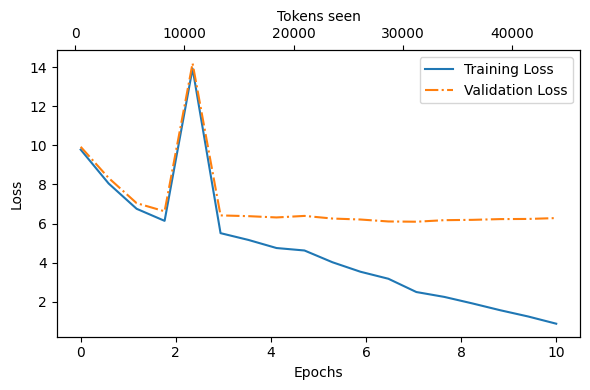

In [17]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(6,4))
    ax1.plot(epochs_seen, train_losses, label="Training Loss")
    ax1.plot(epochs_seen, val_losses, linestyle='-.', label="Validation Loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny() # creates a 2nd x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0) # invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## 5.3

In [18]:
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (mha): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=False)
        (W_k): Linear(in_features=768, out_features=768, bias=False)
        (W_v): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout_sc): Dropout(p=0.1, inplace=False)
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (1): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (mha): MultiHeadAttenti

In [19]:
token_ids = generate_text_simple(model, text_to_token_ids(start_context, tokenizer), 25, GPT_CONFIG_124M["context_len"])
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you know," was one of the picture for nothing--I told Mrs.
"Oh, my work, and went on grop


# 5.3

## 5.3.1

In [20]:
# let some example vocab, output logits be,
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

logits = torch.tensor([4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])
probs = torch.softmax(logits, dim=0)
next_token_id = torch.argmax(probs).item()
print(inverse_vocab[next_token_id])

forward


In [21]:
# instead of doing an argmax, which will always result in the same answer, let us use multinomial sampling

next_token_id = torch.multinomial(probs, num_samples=1).item()

torch.manual_seed(123)
sample = [torch.multinomial(probs, num_samples=1).item() for i in range(1_000)]
sampled_ids = torch.bincount(torch.tensor(sample))
for i, freq in enumerate(sampled_ids):
    print(f"{freq} x {inverse_vocab[i]}")

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


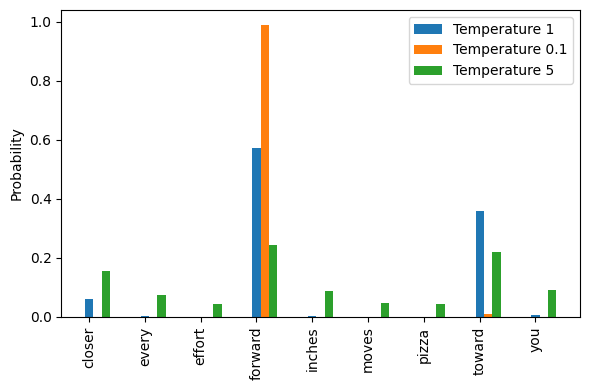

In [22]:
def softmax_w_temp(logits, temperature):
    scaled_logits = logits/temperature
    return torch.softmax(scaled_logits, dim=0)

temperatures = [1, 0.1, 5]
scaled_probs = [softmax_w_temp(logits, T) for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(6,4))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i*bar_width, scaled_probs[i], bar_width, label=f"Temperature {T}")
ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

### 5.3.2

In [23]:
top_k = 3
top_logits, top_pos = torch.topk(logits, top_k)

new_logits = torch.where(
    condition=logits<top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=logits
)
print(new_logits)

topk_probs = torch.softmax(new_logits, dim=0)
print(topk_probs)


tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])
tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### 5.3.3

In [24]:
def generate(model, idx, max_new_tokens, context_len, temp=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_len:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits<min_val, torch.tensor(float("-inf")), logits)
        
        if temp>0:
            logits = logits / temp
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [25]:
torch.manual_seed(123)
token_ids = generate(
    model, text_to_token_ids(start_context, tokenizer), 15, GPT_CONFIG_124M["context_len"], 1.4, 10 
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you know began to my surprise, one--I was no told Mrs.



## 5.4

In [26]:
# saving only model weights
torch.save(model.state_dict(), "model.pth")

In [27]:
# loading
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location=device))

C:\Users\YASHWANTH\AppData\Local\Temp\ipykernel_20612\1370037816.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth", map_locati

<All keys matched successfully>

In [28]:
# to save optim data also

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optim.pth"
)